# 2. data from pmc data

In [0]:
import pandas as pd
import spacy
import numpy as np
from os import listdir
import seaborn as sns
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,f1_score,average_precision_score
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from scipy.sparse import  hstack
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from google.colab import drive

In [18]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
base_dir='/content/gdrive/My Drive/work/RA/COVID-19 Literature Navigator/dsi challenge/classification/'
cite_count=pd.read_csv(base_dir+'pmc_data/0423_cite_count.txt',sep='\t',header=None)

In [0]:
cite_count_dict=defaultdict(int)
with open(base_dir+'pmc_data/0423_cite_count.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 
for i in content:
    i=i.split('\t')
    cite_count_dict[i[0]]=i[1]

In [0]:
#generate LitCovid Data Set
base_dir_new='LitCovid/'
all_file_names=listdir(base_dir+base_dir_new)
def read_generate_labelled_files(base_dir,file_names):
    appended_data = []
    for file_name in file_names:
        data=pd.read_csv(base_dir+file_name,sep='\t')
        data['label']=file_name[:-4]
        appended_data.append(data)
    appended_data = pd.concat(appended_data,ignore_index=True).iloc[:,:4]
    return appended_data
data=read_generate_labelled_files(base_dir+base_dir_new,all_file_names)
data['pmid'] = data['pmid'].astype(str).replace('\.0', '', regex=True)

#generate pmid and label dict
pmid_label_dict=defaultdict(str)
for i,j in zip(data.pmid,data.label):
  pmid_label_dict[i]=j

In [0]:
meta_data = pd.read_csv(base_dir+'pmc_data/meta_output.txt',names=['index',"pmid", "id", "title", "time"],sep='\t')
meta_data=meta_data[meta_data['pmid'].isin(pmid_label_dict)]

In [0]:
cite_pair_dict=defaultdict(list)
with open(base_dir+'pmc_data/0423_cite_pair.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 
col_list=[]
for i in content:   
    i=i.split('\t')
    if int(i[0]) in meta_data.index.values:
      col_list.append(int(i[1]))
      cite_pair_dict[int(i[0])].append(int(i[1]))
new_cite_pair_dict=defaultdict(list)

#remove index that does not exist in cite_pair_dict keys
c_index=0
for i,j in cite_pair_dict.items():
  new_cite_pair_dict[c_index]=j
  c_index+=1

#remove index that does not exist in cite_pair_dict values
cc_index=0
col_dict=defaultdict(int)
for i in sorted(list(set(col_list))):
  col_dict[i]=cc_index
  cc_index+=1

In [0]:
y=[]
list2=[]
for i in cite_pair_dict:
  list2.append(i)
  c_pmid=meta_data[meta_data.index==i].pmid.values[0]
  y.append(pmid_label_dict[c_pmid])

In [0]:
#create citation matrix
MAX_COL=len(col_dict)
cite_mat=np.zeros((c_index,MAX_COL+1))
for key,values in new_cite_pair_dict.items():
    for i in values:
        cite_mat[key][col_dict[i]]=1

In [0]:
le = LabelEncoder()
y=le.fit_transform(y)

#### citation matrix for classification and prediction

#### Here I try to convert the cite pair information into a big 2D matrix with each row representing each paper id and each column representating each citation paper id. The idea is like one hot encoding, if there is a citation pair, the corresponding entry will be marked one.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(cite_mat, y,train_size=0.8,shuffle=True,stratify=y)
plot_data=[["Method", "score", "step"]]

In [39]:
lr=LogisticRegression(max_iter=5000).fit(X_train,y_train)
print('logistic regression - val score:')
train_score=lr.score(X_train,y_train)
print(train_score)
plot_data.append(['logistic regression',train_score,'train'])
print('logistic regression - test score:')
test_score=lr.score(X_test,y_test)
print(test_score)
plot_data.append(['logistic regression',test_score,'test'])

logistic regression - val score:
0.6618421052631579
logistic regression - test score:
0.37894736842105264


In [40]:
lsvc=LinearSVC(max_iter=5000).fit(X_train,y_train)
print('linear svc - val score:')
train_score=lsvc.score(X_train,y_train)
print(train_score)
plot_data.append(['linear svc',train_score,'train'])
print('linear svc - test score:')
test_score=lsvc.score(X_test,y_test)
print(test_score)
plot_data.append(['linear svc',test_score,'test'])

linear svc - val score:
0.7328947368421053
linear svc - test score:
0.33157894736842103


In [41]:
knn=KNeighborsClassifier().fit(X_train,y_train)
print('knn - val score:')
train_score=knn.score(X_train,y_train)
print(train_score)
plot_data.append(['knn',train_score,'train'])
print('knn - test score:')
test_score=knn.score(X_test,y_test)
print(test_score)
plot_data.append(['knn',test_score,'test'])

knn - val score:
0.5144736842105263
knn - test score:
0.24210526315789474


In [42]:
knn=KNeighborsClassifier().fit(X_train,y_train)
print('knn - val score:')
train_score=knn.score(X_train,y_train)
print(train_score)
#plot_data.append(['knn',train_score,'train'])
print('knn - test score:')
test_score=knn.score(X_test,y_test)
print(test_score)
#plot_data.append(['knn',test_score,'test'])

knn - val score:
0.5144736842105263
knn - test score:
0.24210526315789474


In [43]:
rf = RandomForestClassifier(warm_start=True)
rf.fit(X_train,y_train)
print('random forest - val score:')
train_score=rf.score(X_train,y_train)
print(train_score)
plot_data.append(['rf',train_score,'train'])
print('random forest - test score:')
test_score=rf.score(X_test,y_test)
print(test_score)
plot_data.append(['rf',test_score,'test'])

random forest - val score:
0.8394736842105263
random forest - test score:
0.35789473684210527


In [44]:
gb=GradientBoostingClassifier()
gb.fit(X_train,y_train)
print('GradientBoosting - val score:')
train_score=gb.score(X_train,y_train)
print(train_score)
plot_data.append(['GradientBoosting',train_score,'train'])
print('GradientBoosting - test score:')
test_score=gb.score(X_test,y_test)
print(test_score)
plot_data.append(['GradientBoosting',test_score,'test'])

GradientBoosting - val score:
0.7026315789473684
GradientBoosting - test score:
0.3684210526315789


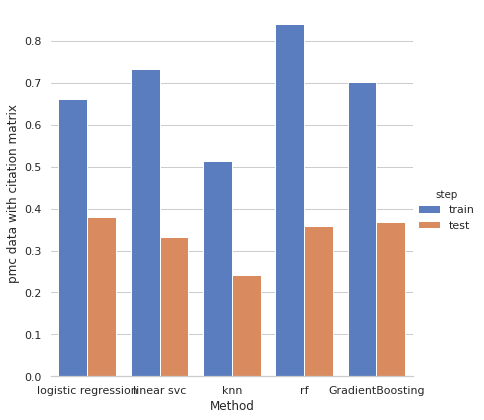

In [45]:
plot_data = pd.DataFrame(plot_data[1:], columns=plot_data[0])
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Method", y="score", hue="step", data=plot_data,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("pmc data with citation matrix ")

#### using KMeans clustering

In [0]:
km = KMeans(n_clusters=10, random_state=0) 
km.fit(cite_mat) 
print(km.cluster_centers_.shape) 
print(km.labels_.shape)  

(10, 5506)
(5506,)


In [0]:
id_label_dict=defaultdict(list)
for i,j in enumerate(km.labels_):
    id_label_dict[j].append(i)    

In [0]:
id_class_dict=defaultdict(str)
index=0
for i in meta_data.iloc[:,0]:
    if i in data.pmid.values:
        id_class_dict[index]=data[data.pmid==i].label.values
    index+=1

In [0]:
def count_label(label_no):
    all_label_list=[]
    for i in id_label_dict[label_no]:
        all_label_list.extend(id_class_dict[i])
    count_label=Counter(all_label_list)
    return count_label

In [0]:
plot_data=[['KMeans label','count','true label']]
for i in range(10):
    a=count_label(i)
    print('---------label '+str(i)+'--------------')
    print(a)
    print()
    for j,k in a.items():
        plot_data.append([i,k,j])

---------label 0--------------
Counter({'Prevention': 600, 'Treatment': 277, 'Diagnosis': 219, 'Mechanism': 172, 'Transmission': 126, 'general': 93, 'CaseReport': 88, 'EpidemicForecasting': 46})

---------label 1--------------
Counter({'Prevention': 31, 'Mechanism': 22, 'Diagnosis': 20, 'Treatment': 13, 'CaseReport': 9, 'Transmission': 6, 'EpidemicForecasting': 5})

---------label 2--------------
Counter({'Prevention': 81, 'Treatment': 38, 'Diagnosis': 35, 'Mechanism': 34, 'Transmission': 25, 'CaseReport': 12, 'EpidemicForecasting': 12, 'general': 7})

---------label 3--------------
Counter({'Prevention': 2, 'Diagnosis': 1, 'Treatment': 1})

---------label 4--------------
Counter({'Mechanism': 10, 'Diagnosis': 10, 'Prevention': 8, 'Treatment': 6, 'Transmission': 5, 'CaseReport': 3, 'EpidemicForecasting': 1, 'general': 1})

---------label 5--------------
Counter({'Treatment': 15, 'Prevention': 15, 'Mechanism': 9, 'Diagnosis': 7, 'CaseReport': 7, 'general': 5, 'Transmission': 2, 'Epidemi

In [0]:
plot_data

,KMeans label,count,true label
0,0,219,Diagnosis
1,0,172,Mechanism
2,0,600,Prevention
3,0,277,Treatment
4,0,126,Transmission
...,...,...,...
67,9,17,Diagnosis
68,9,20,Prevention
69,9,10,Transmission
70,9,6,CaseReport


After clustering, I related this kmeans result with the label generated by LitCovid website.

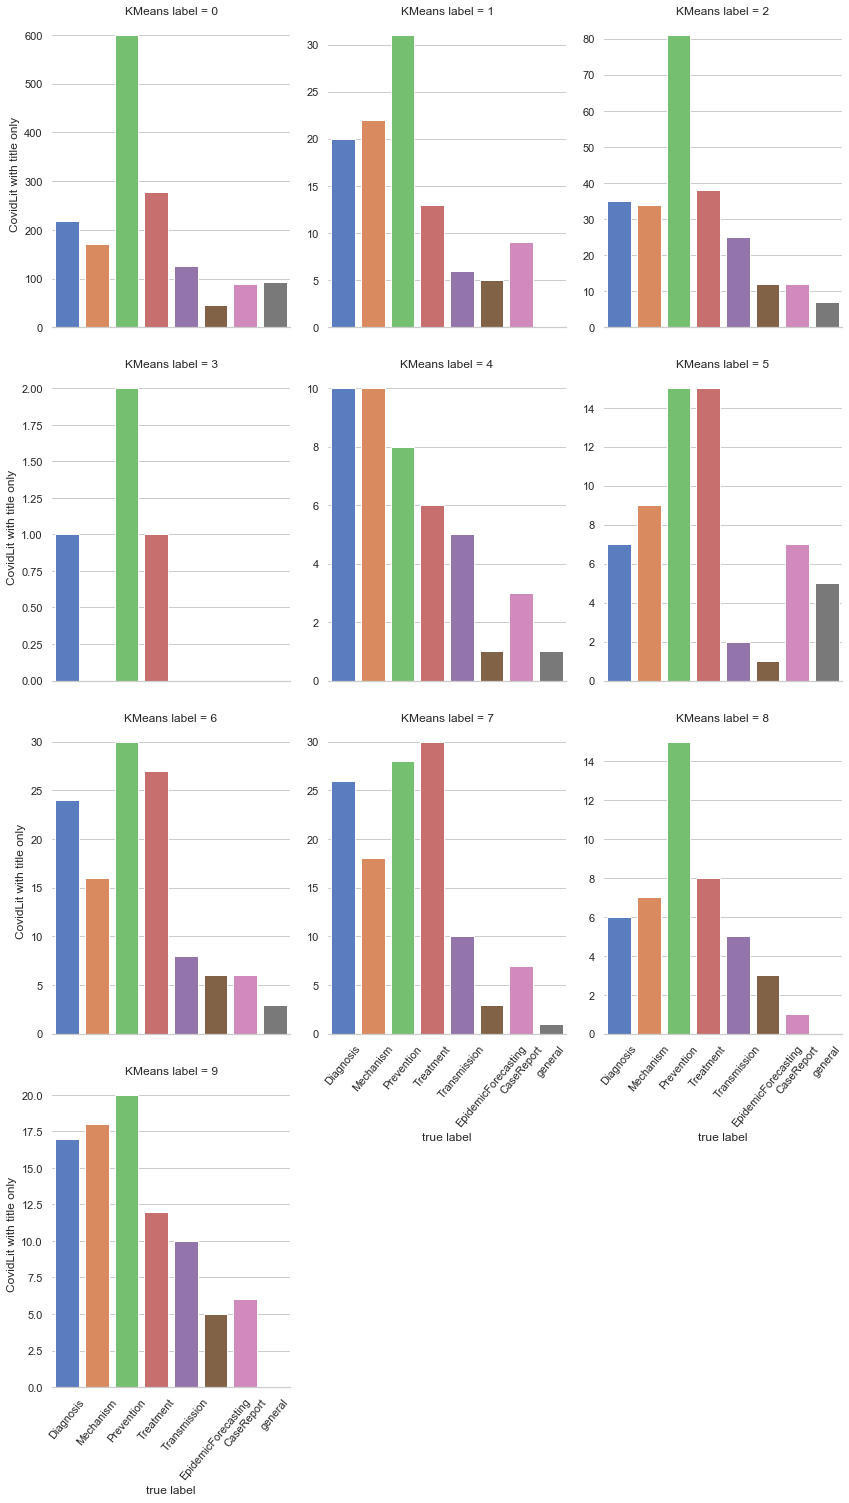

In [0]:
plot_data = pd.DataFrame(plot_data)
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot('true label',col='KMeans label', y="count",col_wrap=3,
                 data=plot_data,
                height=5, kind="bar", palette="muted",aspect=0.8,sharey=False)
g.despine(left=True)
g.set_ylabels("CovidLit with title only")
g.set_xticklabels(rotation=50)